# Programming Exercise 3: Multi-class Classification and Neural Networks


# Problem Statement

For this exercise, you will use logistic regression and neural networks to recognize handwritten digits (from 0 to 9). Automated handwritten digit recognition is widely used today - from recognizing zip codes (postal codes) on mail envelopes to recognizing amounts written on bank checks. This exercise will show you how the methods you’ve learned can be used for this classification task.

In [1]:
from scipy.io import loadmat
import numpy as np
import scipy.optimize as opt
import matplotlib.pyplot as plt
import multiprocessing as mp
import pandas as pd
from scipy.optimize import minimize

# Loading and visualizing data

In [2]:
data = loadmat('ex3data1.mat')
X = data['X']
y = data['y']

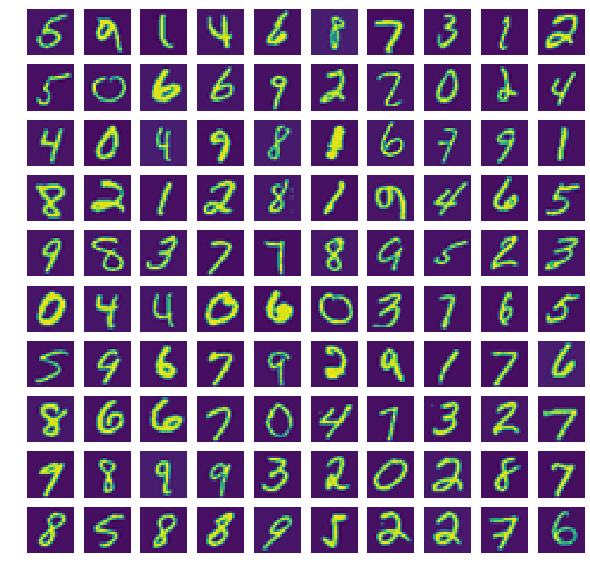

In [3]:
_, axarr = plt.subplots(10,10,figsize=(10,10))
for i in range(10):
    for j in range(10):
        axarr[i,j].imshow(X[np.random.randint(X.shape[0])].reshape((20,20), order = 'F'))          
        axarr[i,j].axis('off')   

# Adding a term for intercept

In [4]:
m = len(y)
ones = np.ones((m, 1))
X = np.hstack((ones, X))
m, n = X.shape
print(X.shape)

(5000, 401)


# Vectorizing Logistic Regression

Vectorizing the cost function

In [5]:
def sigmoid(Z):
    
    return 1/(1 + np.exp(-Z))

In [98]:
def lrCostFunction(theta, X, y, Lambda):
    """
    Takes in numpy array of theta, X, y, and float lambda to compute the regularized logistic cost function 
    """
    
    m=len(y)
    z = sigmoid(np.dot(X, theta))
    J = (-y * np.log(z)) - ((1-y)*np.log(1-z))
    cost = 1/m * sum(J)
    regCost = cost + Lambda/(2*m) * sum(theta[1:]**2)
    # compute gradient
    j_0= 1/m * (np.dot(X.T, (z - y)))[0]
    j_1 = 1/m * (np.dot(X.T, (z - y)))[1:] + (Lambda/m)* theta[1:]
    grad= np.vstack((j_0[:,np.newaxis], j_1))
    return regCost[0], grad

Test

In [87]:
theta_t = np.array([-2,-1,1,2]).reshape(4,1)
X_t =np.array([np.linspace(0.1,1.5,15)]).reshape(3,5).T
X_t = np.hstack((np.ones((5,1)), X_t))
y_t = np.array([1,0,1,0,1]).reshape(5,1)
J, grad = lrCostFunction(theta_t, X_t, y_t, 3)
print("Cost:",J,"Expected cost: 2.534819")
print("Gradients:\n",grad,"\nExpected gradients:\n 0.146561\n -0.548558\n 0.724722\n 1.398003")

Cost: 2.534819396109744 Expected cost: 2.534819
Gradients:
 [[ 0.14656137]
 [-0.54855841]
 [ 0.72472227]
 [ 1.39800296]] 
Expected gradients:
 0.146561
 -0.548558
 0.724722
 1.398003


# Optimizing Parameters

In [88]:
def gradientDescent(X, y, theta, alpha, num_iters, Lambda):
    """
    Take in numpy array X, y and theta and update theta by taking num_iters gradient steps
    with learning rate of alpha
    
    return theta and the list of the cost of theta during each iteration
    """
    
    m=len(y)
    J_history =[]
    
    for i in range(num_iters):
        cost, grad = lrCostFunction(theta,X,y,Lambda)
        theta = theta - (alpha * grad)
        J_history.append(cost)
    
    return theta , J_history

In [89]:
def oneVsAll(X, y, num_labels, Lambda):
    """
    Takes in numpy array of X,y, int num_labels and float lambda to train multiple logistic regression classifiers
    depending on the number of num_labels using gradient descent. 
    
    Returns a matrix of theta, where the i-th row corresponds to the classifier for label i
    """
    m, n = X.shape[0], X.shape[1]
    initial_theta = np.zeros((n,1))
    all_theta = []
    all_J=[]
    
    for i in range(1,num_labels+1):
        theta , J_history = gradientDescent(X, np.where(y==i,1,0),initial_theta,1,300,Lambda)
        all_theta.extend(theta)
        all_J.extend(J_history)
    return np.array(all_theta).reshape(num_labels,n), all_J

In [90]:
all_theta, all_J = oneVsAll(X, y, 10, 0.1)

# Plotting cost function

Text(0.5, 1.0, 'Cost function using Gradient Descent')

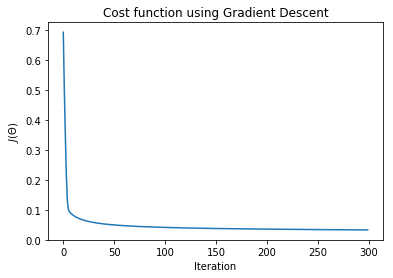

In [91]:
plt.plot(all_J[0:300])
plt.xlabel("Iteration")
plt.ylabel("$J(\Theta)$")
plt.title("Cost function using Gradient Descent")

# One-vs-all Prediction

In [94]:
def predictOneVsAll(all_theta, X):
    """
    Using all_theta, compute the probability of X(i) for each class and predict the label
    
    return a vector of prediction
    """
    predictions = X @ all_theta.T
    return np.argmax(predictions,axis=1)+1

In [95]:
pred = predictOneVsAll(all_theta, X)
print("Training Set Accuracy:",sum(pred[:,np.newaxis]==y)[0]/5000*100,"%")

Training Set Accuracy: 91.46 %


# Neural Networks

Logistic regression cannot form more complex hypotheses as it is only a linear classifier. The neural network will be able to represent complex models that form non-linear hypotheses.

# Loading pre-trained weights 

In [6]:
theta = loadmat('ex3weights.mat')
theta.keys()

dict_keys(['__header__', '__version__', '__globals__', 'Theta1', 'Theta2'])

In [49]:
data = loadmat('ex3data1.mat')
X = data['X']
y = data['y']

In [50]:
Theta1 = theta['Theta1'] # shape = (25, 401)
Theta2 = theta['Theta2'] # shape = (10, 26)

# Feedforward Propagation and Prediction

In [27]:
def predict(theta1, theta2, X):
    m = X.shape[0]
    X = np.hstack((np.ones((m,1)),X))
    a1 = sigmoid(np.dot(X, theta1.T))
    a1 = np.hstack((np.ones((m, 1)), a1)) # hidden layer
    a2 = sigmoid(np.dot(a1, theta2.T))
    
    return np.argmax(a2, axis=1) + 1

In [28]:
pred2 = predict(Theta1, Theta2, X)
print("Training Set Accuracy:", sum(pred2[:,np.newaxis]==y)[0] / 5000*100, "%")

Training Set Accuracy: 97.52 %


# Regularized Cost function

In [29]:
def sigmoidGradient(z):
    g = 1 / (1 + np.exp(-z))
    return g * (1 - g)

In [55]:
def nnCostFunction(nn_params,input_layer_size, hidden_layer_size, num_labels,X, y,Lambda):
    """
    nn_params contains the parameters unrolled into a vector
    
    compute the cost and gradient of the neural network
    """
    # Reshape nn_params back into the parameters Theta1 and Theta2
    Theta1 = nn_params[:((input_layer_size+1) * hidden_layer_size)].reshape(hidden_layer_size,input_layer_size+1)
    Theta2 = nn_params[((input_layer_size +1)* hidden_layer_size ):].reshape(num_labels,hidden_layer_size+1)
    
    m = X.shape[0]
    J=0
    X = np.hstack((np.ones((m,1)),X))
    y10 = np.zeros((m,num_labels)) # one-hot vector for y
    
    a1 = sigmoid(X @ Theta1.T) #shape = (5000, 25)
    a1 = np.hstack((np.ones((m,1)), a1)) #shape = (5000, 26)
    a2 = sigmoid(a1 @ Theta2.T) #shape = (5000, 10)
    
    for i in range(1,num_labels+1): 
        y10[:,i-1][:,np.newaxis] = np.where(y==i,1,0) 
    for j in range(num_labels):
        J = J + sum(-y10[:,j] * np.log(a2[:,j]) - (1 - y10[:,j]) * np.log(1 - a2[:,j]))
    
    cost = 1/m* J
    reg_J = cost + Lambda/(2*m) * (np.sum(Theta1[:,1:]**2) + np.sum(Theta2[:,1:]**2))
    
    # Implement the backpropagation algorithm to compute the gradients
    
    grad1 = np.zeros((Theta1.shape))
    grad2 = np.zeros((Theta2.shape))
    
    for i in range(m):
        xi= X[i,:] # 1 X 401
        a1i = a1[i,:] # 1 X 26
        a2i =a2[i,:] # 1 X 10
        d2 = a2i - y10[i,:] # 1 X 10
        d1 = Theta2.T @ d2.T * sigmoidGradient(np.hstack((1,xi @ Theta1.T))) # 26 X 1
        grad1 = grad1 + d1[1:][:,np.newaxis] @ xi[:,np.newaxis].T # 25 X 401
        grad2 = grad2 + d2.T[:,np.newaxis] @ a1i[:,np.newaxis].T # 10 X 26
    
    grad1 = 1/m * grad1
    grad2 = 1/m * grad2
    
    grad1_reg = grad1 + (Lambda/m) * np.hstack((np.zeros((Theta1.shape[0],1)),Theta1[:,1:]))
    grad2_reg = grad2 + (Lambda/m) * np.hstack((np.zeros((Theta2.shape[0],1)),Theta2[:,1:]))
    
    return cost, grad1, grad2,reg_J, grad1_reg,grad2_reg

In [57]:
input_layer_size  = 400
hidden_layer_size = 25
num_labels = 10
nn_params = np.append(Theta1.flatten(),Theta2.flatten())
J,reg_J = nnCostFunction(nn_params, input_layer_size, hidden_layer_size, num_labels, X, y, 1)[0:4:3]
print("Cost at parameters (non-regularized):",J,"\nCost at parameters (Regularized):",reg_J)

Cost at parameters (non-regularized): 0.28762916516131876 
Cost at parameters (Regularized): 0.3837698590909235


# Random Initialization

In [70]:
def randInitializeWeights(L_in, L_out):
    """
    randomly initializes the weights of a layer with L_in incoming connections and L_out outgoing connections.
    """
    
    epi = (6**1/2) / (L_in + L_out)**1/2
    
    W = np.random.rand(L_out,L_in +1) *(2*epi) -epi
    
    return W

In [71]:
initial_Theta1 = randInitializeWeights(input_layer_size, hidden_layer_size)
initial_Theta2 = randInitializeWeights(hidden_layer_size, num_labels)
initial_nn_params = np.append(initial_Theta1.flatten(),initial_Theta2.flatten())

In [72]:
debug_J  = nnCostFunction(nn_params, input_layer_size, hidden_layer_size, num_labels, X, y, 3)
print("Cost at (fixed) debugging parameters (w/ lambda = 3):",debug_J[3])

Cost at (fixed) debugging parameters (w/ lambda = 3): 0.5760512469501329


# Learning parameters using Gradient descent

In [73]:
def gradientDescentnn(X,y,initial_nn_params,alpha,num_iters,Lambda,input_layer_size, hidden_layer_size, num_labels):
    """
    Take in numpy array X, y and theta and update theta by taking num_iters gradient steps
    with learning rate of alpha
    
    return theta and the list of the cost of theta during each iteration
    """
    Theta1 = initial_nn_params[:((input_layer_size+1) * hidden_layer_size)].reshape(hidden_layer_size,input_layer_size+1)
    Theta2 = initial_nn_params[((input_layer_size +1)* hidden_layer_size ):].reshape(num_labels,hidden_layer_size+1)
    
    m=len(y)
    J_history =[]
    
    for i in range(num_iters):
        nn_params = np.append(Theta1.flatten(),Theta2.flatten())
        cost, grad1, grad2 = nnCostFunction(nn_params,input_layer_size, hidden_layer_size, num_labels,X, y,Lambda)[3:]
        Theta1 = Theta1 - (alpha * grad1)
        Theta2 = Theta2 - (alpha * grad2)
        J_history.append(cost)
    
    nn_paramsFinal = np.append(Theta1.flatten(),Theta2.flatten())
    return nn_paramsFinal , J_history

In [ ]:
nnTheta, nnJ_history = gradientDescentnn(X,y,initial_nn_params,0.8,800,1,input_layer_size, hidden_layer_size, num_labels)
Theta1 = nnTheta[:((input_layer_size+1) * hidden_layer_size)].reshape(hidden_layer_size,input_layer_size+1)
Theta2 = nnTheta[((input_layer_size +1)* hidden_layer_size ):].reshape(num_labels,hidden_layer_size+1)